# Parallel test to validate assumptions required to do a DiD on a log-lin specification

In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned.xlsx')
df.head()

,year,group,count,population,crime_rate_per_100k
0,2009,Foreigner,4654,NaN,NaN
1,2009,Swiss,4238,NaN,NaN
2,2010,Foreigner,4450,1837112.0,242.23
3,2010,Swiss,4047,6103857.0,66.30
4,2011,Foreigner,4197,1896723.0,221.28


## Visual inspection

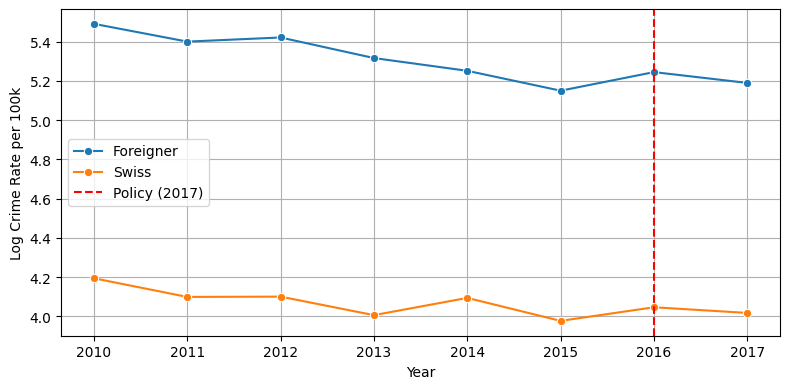

In [42]:
# Clean data (remove rows with missing crime_rate_per_100k)
df = df.dropna(subset=['population'])
df = df[df['crime_rate_per_100k'] > 0].copy()
df['log_crime_rate'] = np.log(df['crime_rate_per_100k'])
df = df[df['year'] <= 2017].copy()



plt.figure(figsize=(8,4))
sns.lineplot(data=df, x='year', y='log_crime_rate', hue='group', marker='o')
plt.axvline(2016, color='red', linestyle='--', label='Policy (2017)')
plt.xlabel("Year"); plt.ylabel("Log Crime Rate per 100k")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/pre_2017_trend_loglin.png", dpi=300, bbox_inches='tight')  
plt.show()

In [43]:
df_pre = df[df['year'] < 2017].copy()  
df_pre['t'] = df_pre['year'] - df_pre['year'].min()  
df_pre['T'] = (df_pre['group'] == 'Foreigner').astype(int)  
df_pre['T_t'] = df_pre['T'] * df_pre['t'] 

## Linear Interaction Test

$\log({CrimeRate}_{gt}) = \alpha + \gamma T_g + \lambda t + \beta (T_g \times t) + \varepsilon_{gt}$


In [44]:
# Group × Year linear interaction test
m2 = smf.ols("log_crime_rate ~ T + year + T:year", data=df_pre).fit()
print("\n--- Group × Year Interaction Test ---")
print(m2.summary())


--- Group × Year Interaction Test ---
                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     666.3
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           8.26e-12
Time:                        23:17:18   Log-Likelihood:                 23.685
No. Observations:                  14   AIC:                            -39.37
Df Residuals:                      10   BIC:                            -36.81
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)



## Event-Study Pre-Trends Test

$\log({CrimeRate}_{cgt}) = \gamma T_g + \sum_{y=2010}^{2016} \delta_y \cdot \mathbf{1}\{Year = y\} + \sum_{y=2010}^{2016} \theta_y \cdot (T_g \times \mathbf{1}\{Year = y\}) + \alpha_c + \varepsilon_{cgt}$


**Null hypothesis**:  
$H_{0}:\;\theta_{2010}=\theta_{2011}=\dots=\theta_{2016}=0.$

In [45]:
df_pre = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned_by_canton.xlsx")

# Pre‐treatment & log‐transform
df_pre = df_pre[df_pre['year'] < 2017].copy()
df_pre = df_pre[df_pre['crime_rate_per_100k'] > 0]
df_pre['log_crime_rate'] = np.log(df_pre['crime_rate_per_100k'])

# Dummies
df_pre['FG'] = (df_pre['group']=='Foreigner').astype(int)
df_pre['year_cat'] = df_pre['year'].astype('category')

# Event‐study regression with canton fixed effects
model = smf.ols("log_crime_rate ~ FG + C(year_cat) + C(year_cat):FG + C(canton)",
                data=df_pre).fit(cov_type='cluster', cov_kwds={'groups': df_pre['canton']})

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_crime_rate   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     207.9
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           6.79e-20
Time:                        23:17:18   Log-Likelihood:                -123.60
No. Observations:                 272   AIC:                             319.2
Df Residuals:                     236   BIC:                             449.0
Df Model:                          35                                         
Covariance Type:              cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 35, but rank is 13
  warnings.warn('covariance of constraints does not have full '


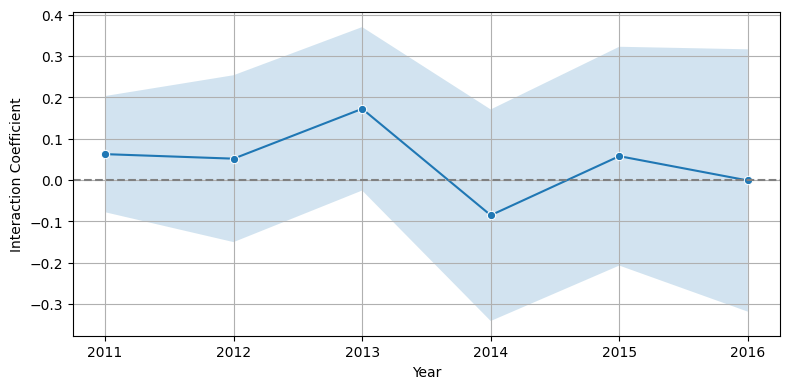

In [46]:
# Extract and plot θ_y = the Foreigner×Year interactions
ints = model.params.filter(like="C(year_cat)[T.").filter(like=":FG")  # Use `like=` as keyword argument
ses = model.bse[ints.index]

# Extract years from coefficient names (e.g., "C(year_cat)[T.2011]:FG" → 2011)
years = [int(s.split('T.')[1].split(']')[0]) for s in ints.index]

# Plot
plt.figure(figsize=(8, 4))
sns.lineplot(x=years, y=ints.values, marker='o')
plt.fill_between(years, ints - 1.96*ses, ints + 1.96*ses, alpha=0.2)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Year"); plt.ylabel("Interaction Coefficient")
plt.grid(True); plt.tight_layout()
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/foreigner_year_interaction.png", dpi=300, bbox_inches='tight')  
plt.show()

In [47]:
# Get all interaction terms
interaction_terms = [
    term for term in model.params.index 
    if "C(year_cat)[T." in term and ":FG" in term
]

# Formulate the null hypothesis: θ_2011 = θ_2012 = ... = 0
hypothesis = " + ".join(interaction_terms) + " = 0"

# Perform the test
joint_test = model.f_test(hypothesis)
print("\nJoint Test for All Foreigner×Year Interactions = 0")
print(f"F-statistic: {joint_test.fvalue:.2f}")
print(f"p-value: {joint_test.pvalue:.4f}")


Joint Test for All Foreigner×Year Interactions = 0
F-statistic: 0.32
p-value: 0.5748


## Specification : Box-Cox transformation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Optimal λ≈ 0.250
Approx 95% CI: [0.170, 0.340]


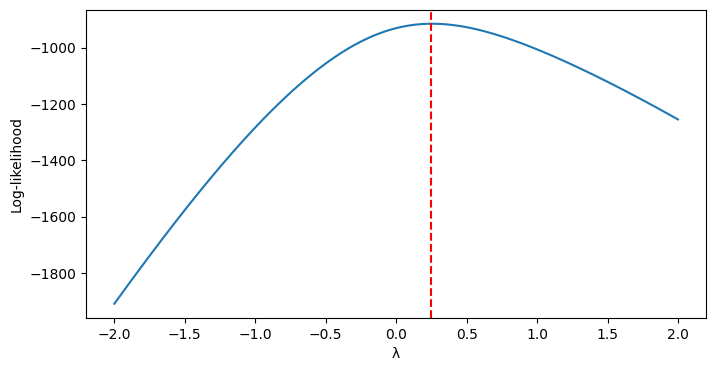

In [48]:
df_ct = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned_by_canton.xlsx")

df_ct['log_crime_rate'] = np.log(df_ct['crime_rate_per_100k'])
df_ct = df_ct[df_ct['log_crime_rate']>=0]
df_ct['T'] = (df_ct['group']=="Foreigner").astype(int)
df_ct['P'] = (df_ct['year']>=2017).astype(int)
df_ct['T_P'] = df_ct['T'] * df_ct['P']
df_ct['t'] = df_ct['year'] - df_ct['year'].min()
df_ct['T_t'] = df_ct['T'] * df_ct['t']

# 1) Pre‐treatment subset
df_pre = df_ct[df_ct['year'] < 2017].copy()
y = df_pre['crime_rate_per_100k'].values
n = len(y)

# 2) Set up grid of λ
lambdas = np.linspace(-2, 2, 401)
llf = []

# 3) Loop: transform, regress on FEs, compute log‐likelihood
for lam in lambdas:
    if abs(lam) < 1e-6:
        yt = np.log(y)
    else:
        yt = (y**lam - 1) / lam

    df_pre['yt'] = yt

    mod = smf.ols("yt ~ C(canton) + C(group)", data=df_pre).fit()
    rss = np.sum(mod.resid**2)

    ll = - (n/2) * np.log(rss / n) + (lam - 1) * np.sum(np.log(y))
    llf.append(ll)

# Gather and find optimum
df_bc = pd.DataFrame({'lambda': lambdas, 'llf': llf})
best = df_bc.loc[df_bc['llf'].idxmax()]

print(f"Optimal λ≈ {best['lambda']:.3f}")
# Optionally: 95% CI where llf ≥ max(llf) - χ²(1,0.95)/2 ≈ drop of 1.92
crit = best['llf'] - 1.92
ci = df_bc.loc[df_bc['llf'] >= crit, 'lambda'].agg(['min','max'])
print(f"Approx 95% CI: [{ci['min']:.3f}, {ci['max']:.3f}]")

# Show the full profile
plt.figure(figsize=(8,4))
plt.plot(df_bc['lambda'], df_bc['llf'])
plt.axvline(best['lambda'], color='red', linestyle='--')
plt.xlabel('λ')
plt.ylabel('Log‐likelihood')
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/BoxCoxProfile.png", dpi=300, bbox_inches='tight')  
plt.show()

Optimal λ ≈ 0.250
Approx. 95% CI: [0.170, 0.340]


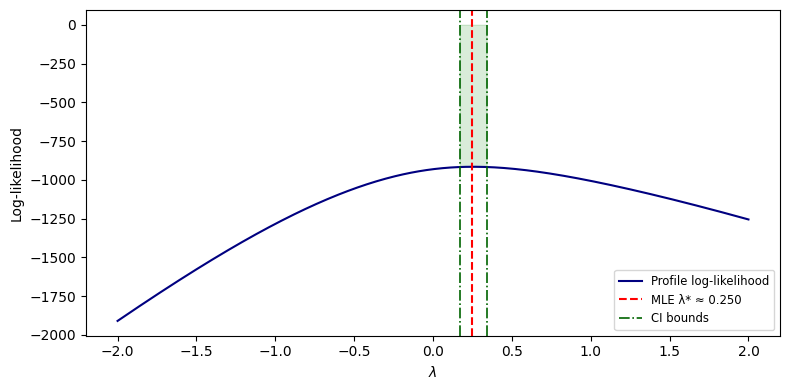

In [49]:
# Load and prepare data 

df_ct['log_crime_rate'] = np.log(df_ct['crime_rate_per_100k'])
df_ct = df_ct[df_ct['year'] < 2017].copy()

df_ct = df_ct[df_ct['crime_rate_per_100k'] > 0]
y = df_ct['crime_rate_per_100k'].values
n = len(y)

lambdas = np.linspace(-2, 2, 401)
llf      = []

for lam in lambdas:
    # Box–Cox transform
    if abs(lam) < 1e-6:
        yt = np.log(y)
    else:
        yt = (y**lam - 1) / lam

    # Attach transformed outcome back to df
    df_ct['yt'] = yt

    # Fit a simple FE model: yt ~ C(canton) + C(group)
    mod = smf.ols("yt ~ C(canton) + C(group)", data=df_ct).fit()
    rss = np.sum(mod.resid**2)

    # Compute log-likelihood (up to additive constant)
    #   ℓ(λ) = −(n/2)·ln(RSS/n) + (λ − 1)·Σ ln y
    ll = - (n / 2) * np.log(rss / n) + (lam - 1) * np.sum(np.log(y))
    llf.append(ll)

# Package results, find MLE and confidence interval
df_bc = pd.DataFrame({'lambda': lambdas, 'llf': llf})
best_idx = df_bc['llf'].idxmax()
best     = df_bc.loc[best_idx]

# 95% CI cutoff for χ²(1, 0.95)/2 ≈ 1.92
ll_crit = best['llf'] - 1.92
ci_band = df_bc[df_bc['llf'] >= ll_crit]['lambda']
ci_min, ci_max = ci_band.min(), ci_band.max()

print(f"Optimal λ ≈ {best['lambda']:.3f}")
print(f"Approx. 95% CI: [{ci_min:.3f}, {ci_max:.3f}]")

# Plot the profile with shaded 95%‐CI and vertical lines
plt.figure(figsize=(8, 4))
plt.plot(df_bc['lambda'], df_bc['llf'], color='navy', lw=1.5, label='Profile log‐likelihood')
plt.axvline(best['lambda'], color='red', ls='--', lw=1.5, label=f"MLE λ* ≈ {best['lambda']:.3f}")
plt.axvline(ci_min, color='darkgreen', ls='-.', lw=1.2, label=f"CI bounds")
plt.axvline(ci_max, color='darkgreen', ls='-.', lw=1.2)

# Shade between [ci_min, ci_max]
plt.fill_between(
    df_bc['lambda'],
    df_bc['llf'],
    where=(df_bc['lambda'] >= ci_min) & (df_bc['lambda'] <= ci_max),
    color='green',
    alpha=0.15
)

plt.xlabel(r"$\lambda$")
plt.ylabel("Log‐likelihood")
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.savefig(
    "/Users/souhil/Desktop/Courses/Recherche Empirique/Final/BoxCoxProfile_with_CI.png",
    dpi=300, bbox_inches='tight'
)
plt.show()

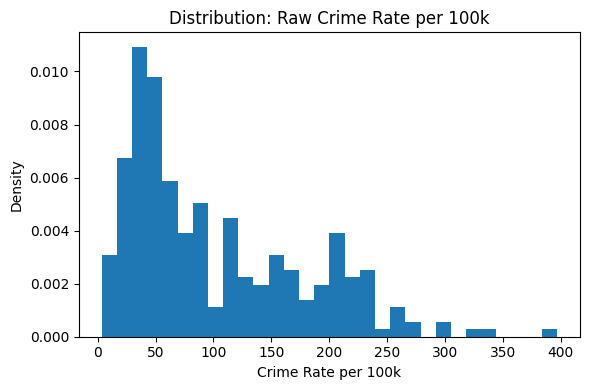

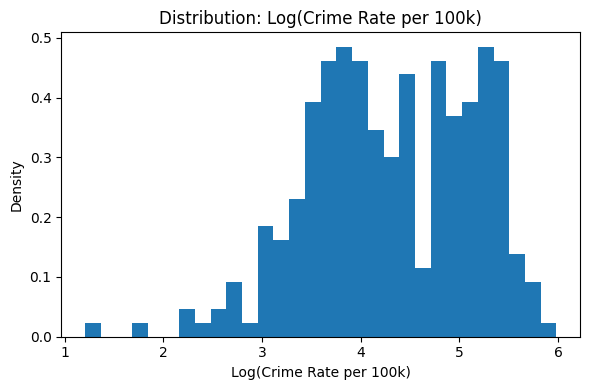

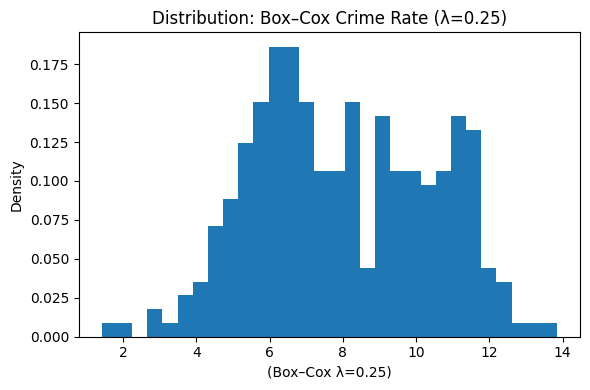

In [50]:
# Extract the variable
y = df_ct['crime_rate_per_100k'].values

# Compute log and Box-Cox transforms
log_y = np.log(y)
lam = 0.25  # optimal lambda from Box-Cox
bc_y = (y**lam - 1) / lam

# 1) Raw levels
plt.figure(figsize=(6,4))
plt.hist(y, bins=30, density=True)
plt.title("Distribution: Raw Crime Rate per 100k")
plt.xlabel("Crime Rate per 100k")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# 2) Log transform
plt.figure(figsize=(6,4))
plt.hist(log_y, bins=30, density=True)
plt.title("Distribution: Log(Crime Rate per 100k)")
plt.xlabel("Log(Crime Rate per 100k)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# 3) Box-Cox transform
plt.figure(figsize=(6,4))
plt.hist(bc_y, bins=30, density=True)
plt.title(f"Distribution: Box–Cox Crime Rate (λ={lam:.2f})")
plt.xlabel(f"(Box–Cox λ={lam:.2f})")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

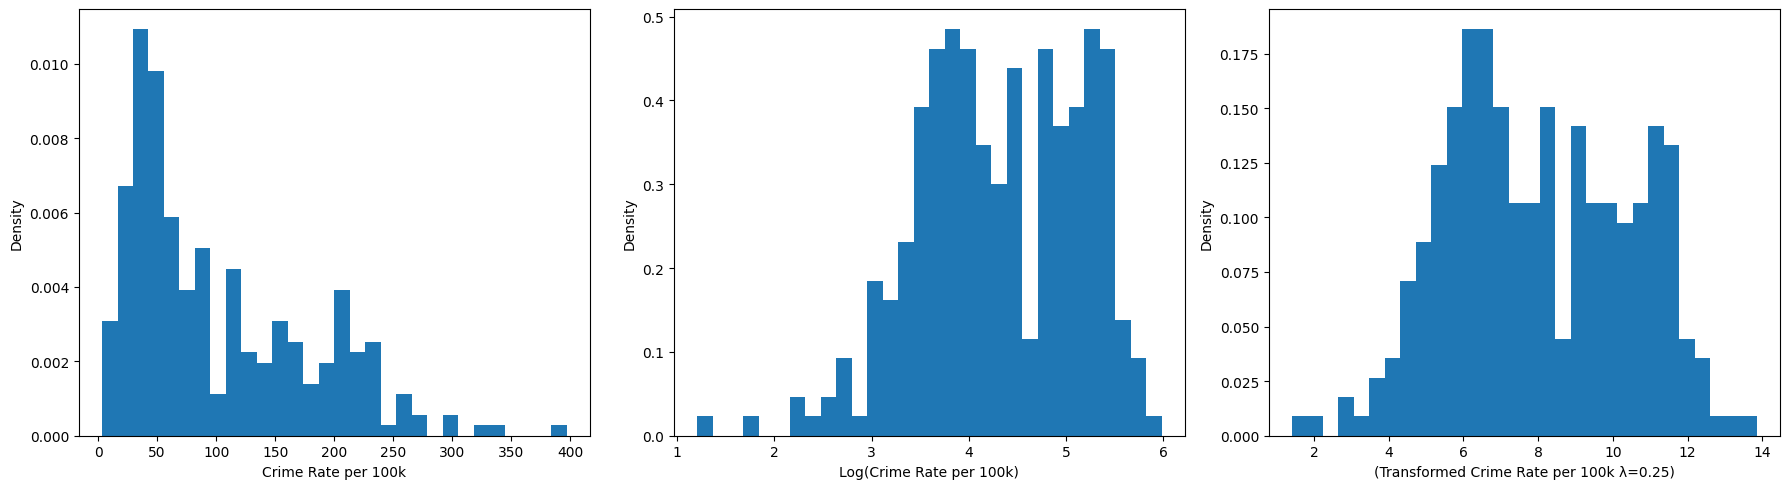

In [51]:
# Create a single figure with 3 subplots side by side
plt.figure(figsize=(18, 5)) 

# Raw levels
plt.subplot(1, 3, 1)
plt.hist(y, bins=30, density=True)
plt.xlabel("Crime Rate per 100k")
plt.ylabel("Density")

# Log transform
plt.subplot(1, 3, 2)
plt.hist(log_y, bins=30, density=True)
plt.xlabel("Log(Crime Rate per 100k)")
plt.ylabel("Density")

# Box-Cox transform
plt.subplot(1, 3, 3)
plt.hist(bc_y, bins=30, density=True)
plt.xlabel(f"(Transformed Crime Rate per 100k λ={lam:.2f})")
plt.ylabel("Density")

plt.tight_layout()
plt.savefig(
    "/Users/souhil/Desktop/Courses/Recherche Empirique/Final/crime_rate_transformations.png",
    dpi=300, bbox_inches='tight')
plt.show()